
# How to check all possible target binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome.  Or more general: We have a target sequence and we want to find a subsequence of specified length which is as specific to this target as possible i.e. has the least interactions with dataset of reference sequences. 


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm
import pathlib
from IPython.display import display
from main_search import query_sc_summary, sc_summarize, query_sc, sc_jit
from sequence_reader import read_fasta, _ensembl_fasta_to_dict
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import warnings
import pathlib
import scipy.stats as stats
from joblib import Parallel, delayed
from tqdm import tqdm
import math
from main_search import query_sc_summary, sc_summarize, query_sc, df_PCA, df_map, df_table, _col_weights

## Import data


#### General Fasta importer - mCherry Sequencing results

In [2]:
mCherry = read_fasta("sequence_data/iGEM_mCherry_V2.fasta").iloc[0]
mCherry.SEQUENCE = mCherry.SEQUENCE.upper()
mCherry

SEQ_NAME                               iGEM_mCherry_BBa_E2060
SEQUENCE    ATGGCAACTAGCGGCATGGTTAGTAAAGGAGAAGAAAATAACATGG...
Name: 0, dtype: object

#### read ensembl FASTA and decode description
 - for FASTA data from https://ftp.ensembl.org/pub/

In [3]:
files = ["sequence_data/Saccharomyces_cerevisiae.R64-1-1.ncrna.fa", "sequence_data/Saccharomyces_cerevisiae.R64-1-1.cdna.all.fa", "sequence_data/Saccharomyces_cerevisiae.R64-1-1.cds.all.fa"]  # -> different transcripts in each DataFrame -> data has to be concatenated
_df = pd.concat([read_fasta(file) for file in files], ignore_index=True)
df_seq = pd.concat([_df.SEQ_NAME.apply(_ensembl_fasta_to_dict).apply(pd.Series), _df.SEQUENCE], axis = 1).drop_duplicates(ignore_index = True) # split description into respective columns i.e. decode ensebl fasta description
df_seq

,SEQ_NAME,chromosome,gene,gene_biotype,transcript_biotype,SEQUENCE
0,ETS2-2_rRNA,R64-1-1:XII:460712:460922:-1,ETS2-2,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...
1,ITS2-2_rRNA,R64-1-1:XII:464319:464550:-1,ITS2-2,rRNA,NaN,CCTTCTCAAACATTCTGTTTGGTAGTGAGTGATACTCTTTGGAGTT...
2,RDN18-1_rRNA,R64-1-1:XII:455933:457732:-1,RDN18-1,rRNA,NaN,TATCTGGTTGATCCTGCCAGTAGTCATATGCTTGTCTCAAAGATTA...
3,Q0020_rRNA,R64-1-1:Mito:6546:8194:1,Q0020,rRNA,rRNA,GTAAAAAATTTATAAGAATATGATGTTGGTTCAGATTAAGCGCTAA...
4,RDN5-5_rRNA,R64-1-1:XII:485697:485815:1,RDN5-5,rRNA,NaN,GGTTGCGGCCATATCTACCAGAAAGCACCGTTTCCCGTCCGATCAA...
...,...,...,...,...,...,...
7035,YIL170W,R64-1-1:IX:19847:21220:1,YIL170W,pseudogene,pseudogene,ATGGGTTTGATTGTCTCAATATTCAACATTGGCTGCGCCATAGGCG...
7036,YMR242C_mRNA,R64-1-1:XIII:753225:753742:-1,YMR242C,protein_coding,protein_coding,GCTCACTTTAAAGAATACCAAGTTATTGGCCGTCGTTTGCCAACTG...
7037,YOR312C_mRNA,R64-1-1:XV:900250:900767:-1,YOR312C,protein_coding,protein_coding,GCTCATTTCAAAGAATACCAAGTCATTGGTCGTCGTTTACCAACTG...
7038,YJL041W_mRNA,R64-1-1:X:365903:368373:1,YJL041W,protein_coding,protein_coding,AACTTCAATACACCTCAACAAAACAAAACGCCCTTTTCGTTCGGGA...


#### read TPM.tsv files - quantitative transcriptome
data from https://www.ebi.ac.uk/gxa/experiments?species=%22saccharomyces+cerevisiae%22&experimentType=%22Baseline%22

In [4]:
files = ["sequence_data/E-MTAB-8621-query-results.tpms.tsv", "sequence_data/E-MTAB-8626-query-results.tpms.tsv"] # same genes under different conditions -> data has to be merged
_df = pd.read_csv(files[0], sep = '\t', skiprows = 4)
for file in files[1:]:
    _df = pd.merge(_df, pd.read_csv(file, sep = '\t', skiprows = 4) , how = "outer", on = ["Gene ID", "Gene Name"])

df_tpm = _df.drop(columns = _df.filter(like="minute").columns) # combine timeseries data by taking the max of the found expression
df_tpm["tpm_max"] = _df.filter(like="minute").max(axis = 1, skipna = True, numeric_only = True)
df_tpm

,Gene ID,Gene Name,tpm_max
0,ETS1-1,ETS1-1,72.0
1,ETS1-2,ETS1-2,3.0
2,ETS2-1,ETS2-1,8.0
3,HRA1,HRA1,3.0
4,ICR1,ICR1,5.0
...,...,...,...
6782,tY(GUA)F2,SUP6,3.0
6783,tY(GUA)J1,SUP7,9.0
6784,tY(GUA)J2,SUP4,3.0
6785,tY(GUA)M1,SUP5,6.0


### merge sequence and tpm data

In [5]:
transcriptome = pd.merge(df_seq, df_tpm, left_on="gene", right_on="Gene ID", how = "outer") 
transcriptome = transcriptome[~transcriptome.SEQUENCE.isna()]                               # delete entries witho9ut a sequence
transcriptome.loc[transcriptome.tpm_max.isna(), "tpm_max"] = transcriptome.tpm_max.max()                   # if transcript count (TPM) is unknown, expect the worst
transcriptome["WEIGHT"] = transcriptome.tpm_max
mCherry["WEIGHT"] = transcriptome.tpm_max.mean()
transcriptome

,SEQ_NAME,chromosome,gene,gene_biotype,transcript_biotype,SEQUENCE,Gene ID,Gene Name,tpm_max,WEIGHT
0,ETS1-1_rRNA,R64-1-1:XII:457733:458432:-1,ETS1-1,rRNA,NaN,ATGCGAAAGCAGTTGAAGACAAGTTCGAAAAGAGTTTGGAAACGAA...,ETS1-1,ETS1-1,72.0,72.0
1,ETS1-2_rRNA,R64-1-1:XII:466870:467569:-1,ETS1-2,rRNA,NaN,ATGCGAAAGCAGTTGAAGACAAGTTCGAAAAGAGTTTGGAAACGAA...,ETS1-2,ETS1-2,3.0,3.0
2,ETS2-1_rRNA,R64-1-1:XII:451575:451785:-1,ETS2-1,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...,ETS2-1,ETS2-1,8.0,8.0
3,ETS2-2_rRNA,R64-1-1:XII:460712:460922:-1,ETS2-2,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...,NaN,NaN,22546.0,22546.0
4,HRA1_ncRNA,R64-1-1:I:99305:99868:1,HRA1,ncRNA,NaN,GGGCCCTTTCTTCCGTTTGAACGTAAAGGCATTTTTGAGACCATTA...,HRA1,HRA1,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...
7083,tY(GUA)J2_tRNA,R64-1-1:X:542956:543044:-1,tY(GUA)J2,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,tY(GUA)J2,SUP4,3.0,3.0
7084,tY(GUA)M1_tRNA,R64-1-1:XIII:168795:168883:1,tY(GUA)M1,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,tY(GUA)M1,SUP5,6.0,6.0
7085,tY(GUA)M2_tRNA,R64-1-1:XIII:837928:838016:1,tY(GUA)M2,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,NaN,NaN,22546.0,22546.0
7086,tY(GUA)O_tRNA,R64-1-1:XV:288192:288280:1,tY(GUA)O,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,tY(GUA)O,SUP3,3.0,3.0



## Test all possible candidate binding sequences (in parallel)
 - compare all target-sequence substrings of specific length to reference dataset


In [ ]:
# generate random input sequences for this test
reference_dataset = transcriptome        # The references to check against, i.e. the transcriptome in this example
target            = mCherry              # The sequence from which we want ot find the best/unique binding site
query_len = 12                           # length of the binding sites (usually 8-12 for pumby)

# generate dataset of all possible binding sequences
query_dataset = pd.DataFrame([{"POSITION": k, "SEQ_NAME": target.SEQ_NAME + f"_{k:03d}:{k+query_len:03d}", "SEQUENCE":target.SEQUENCE[k:k+query_len], "WEIGHT":1} for k in range(len(target.SEQUENCE)-query_len)] )

# compare possible binding sites against whole transcriptome
query_sc_summary(query_dataset.sample().iloc[0], reference_dataset, target) # testrun to make sure everything is ok, because for some stupid reason parallelised executions do not return warnings anymore
results = pd.DataFrame(list(tqdm(total=len(query_dataset), ncols = 100, 
        iterable=Parallel(return_as="generator", n_jobs=-1)(  # using joblib instead of multiprocessing becasue of windows compatibility
            delayed(query_sc_summary)(query, reference_dataset, target) for _, query in query_dataset.iterrows())
        )))

100%|█████████████████████████████████████████████████████████████| 757/757 [00:58<00:00, 13.04it/s]


In [13]:
DF = results.copy()

position_cols = [col for col in DF.columns if col.startswith("POSITION")]
DFnum = DF.select_dtypes(np.number).drop(position_cols, axis = 1)
rel_ranks = (DFnum.rank() + DFnum.rank(method = "dense"))/ (2*len(DF) +1) # relative total number, i.e. within 0...1
weighted_ranks = 2**(rel_ranks.apply(stats.norm.ppf)) * DFnum.apply(_col_weights)  

DF["rank max"] = weighted_ranks.max(axis = 1) 
DF["rank sum"] = weighted_ranks.mean(axis = 1)  
DF["rank score"] = DF["rank max"] +  DF["rank sum"]
DF["selected"] = 0

DF.loc[DF.POSITION.isin([8, 150, 252, 307, 421, 590, 675]), "selected"] = 1

df_table(DF)

In [14]:
### search for offtarget binding sites of the remaining selection

query_dataset = DF[DF.selected == DF.selected.max()]
sc_refs = pd.concat([pd.DataFrame([target]), reference_dataset], axis = 0)  # include target in sequence comparison

def query_sc_wrapper(query:pd.Series, reference_dataset:pd.DataFrame)->pd.DataFrame:
    return [query, query_sc(query, reference_dataset)]

qnsc_results = list(tqdm(total=len(query_dataset), ncols = 100,
        iterable = Parallel(return_as="generator", n_jobs=-1)(
            delayed(query_sc_wrapper)(query, sc_refs) for _, query in query_dataset.iterrows() )))


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.03it/s]


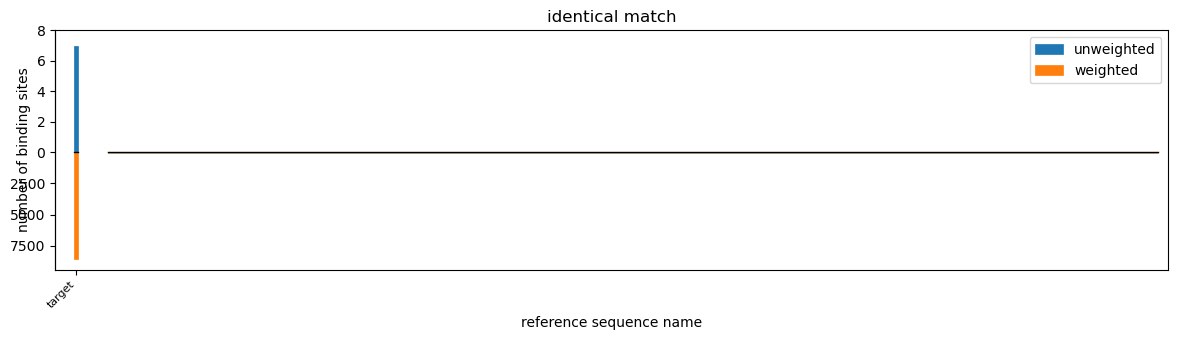

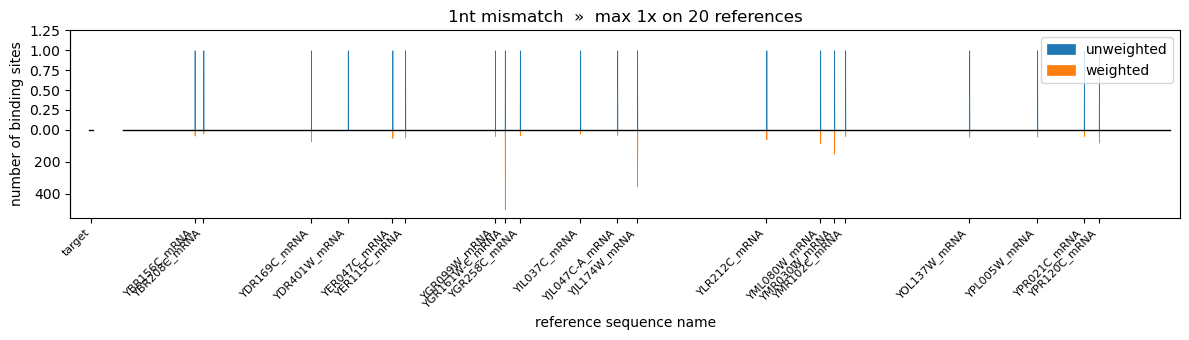

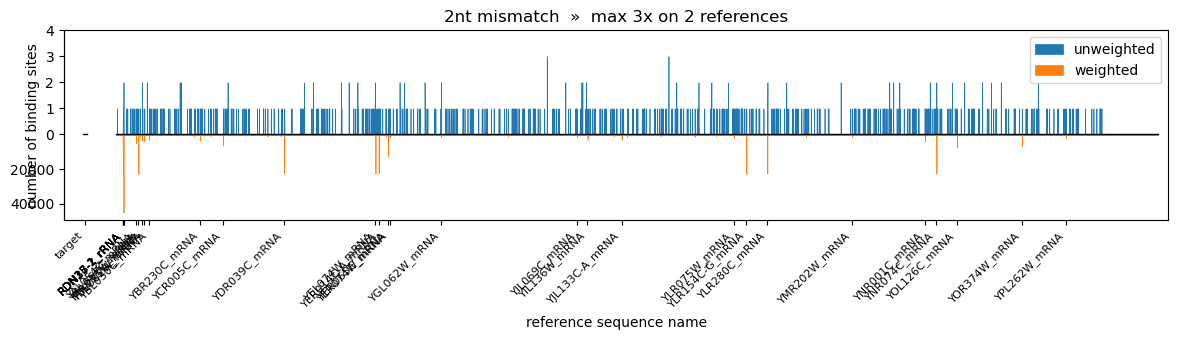

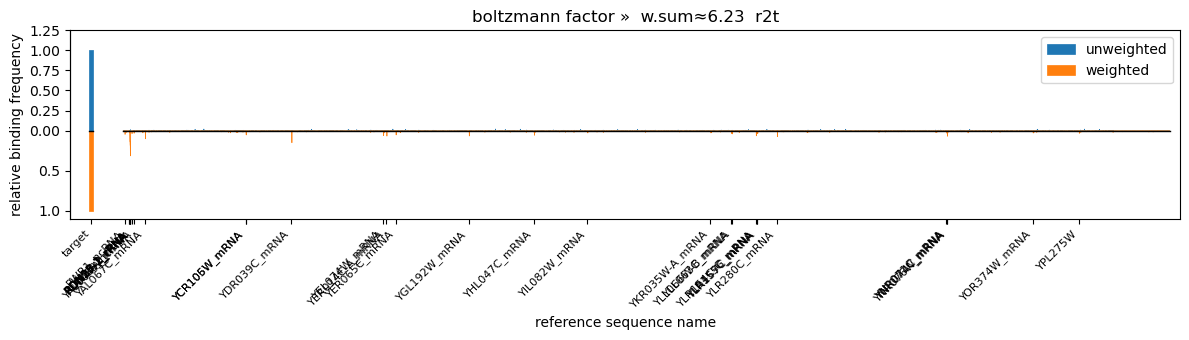

In [17]:
positions = {}
metrics = ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]
weight = 0
for i, (query, scr) in enumerate(qnsc_results):
    positions |= {f"POSITION {i}": query.POSITION}
    weight += query.WEIGHT
    if i == 0:
        references_scr = scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr     = scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0]  # results from the comparison with the target sequence
    else:
        references_scr[metrics] += scr.loc[~(scr.SEQ_NAME == target.SEQ_NAME)].reset_index(drop = True)[metrics]  # results from the comparison with the reference dataset (sequences to avoid)
        target_scr[metrics]     += scr.loc[  scr.SEQ_NAME == target.SEQ_NAME ].reset_index(drop = True).iloc[0][metrics]  # results from the comparison with the target sequence

qcr = sc_summarize(pd.Series(positions|{"WEIGHT": weight}), references_scr,  target_scr, plot = True, VIR_max = 32) # summary of all candidates together
df_table(pd.DataFrame([qcr]))